<span>Imports, loading and initial exploring the dataset</span>

In [3]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [4]:
# Loading dataset into dataframe
data = pd.read_csv("../data/tiktok_dataset.csv")

There are small amount of missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.
***

In [5]:
# Dropping rows with missing values
data = data.dropna(axis=0)

There are no duplicate observations in the data.
***

In [6]:
# Checking class balance
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced. Additionally, **Tree-based models** are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

<span style="background-color:deepskyblue;
             color:yellow;
             font-size:25px;
             text-align:center;
               border-radius:20px 70px;
             font-weight:bold;
             border:2px solid yellow;
              padding:15px 30px;">Feature engineering
</span>



Now we extract the length (character count) of each `video_transcription_text` and add this to the dataframe as a new column called `text_length` so that it can be used as a feature in the model.

In [7]:
# Creating `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


***

#### Now lets calculate the average `text_length` for claims and opinions. 

In [8]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


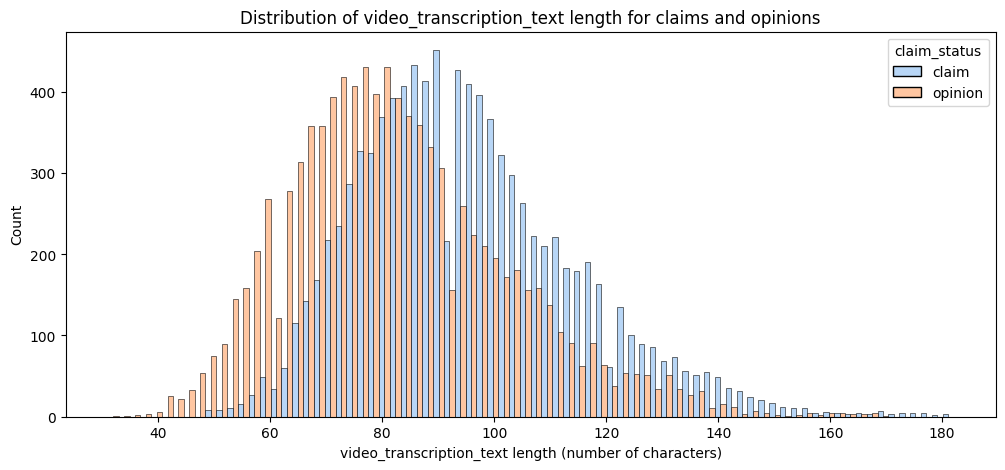

In [9]:
# Visualising the distribution of `text_length` for claims and opinions
# Creating two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about **13 more** on average, as indicated in a previous cell.

# <span style="color:red; font-size:20px;"> Feature selection and transformation</span>

In [10]:
X = data.copy()
# Dropping unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encoding target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


<span style="background-color:deepskyblue;
             color:yellow;
             font-size:25px;
             text-align:center;
               border-radius:20px 70px;
             font-weight:bold;
             border:2px solid yellow;
              padding:15px 30px;">Splitting the data
</span>

Assigning target variable.

**Exemplar response:**
In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In [11]:
# Isolating target variable
y = X['claim_status']

In [12]:
# Isolating features
X = X.drop(['claim_status'], axis=1)

# Displaying first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


<span style="background-color:deepskyblue;
             color:yellow;
             font-size:25px;
             text-align:center;
               border-radius:20px 70px;
             font-weight:bold;
             border:2px solid yellow;
              padding:15px 30px;">Creating train/validate/test sets
</span>

In [13]:
# Splitting the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
# Splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [15]:
# Getting shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

- The number of features (`11`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

<span style="background-color:deepskyblue;
             color:yellow;
             font-size:25px;
             text-align:center;
               border-radius:20px 70px;
             font-weight:bold;
             border:2px solid yellow;
              padding:15px 30px;">Tokenizing text column
</span>

The feature `video_transcription_text` is text-based. It is not a categorical variable, since it does not have a fixed number of possible values. One way to extract numerical features from it is through a bag-of-words algorithm like [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

`CountVectorizer` works by splitting text into n-grams, which are groups of n consecutive words. For instance, "a dime for a cup of coffee" (phrase A) broken into 2-grams would result in six two-word combinations:

`a dime` | `dime for` |`for a`| `a cup` | `cup of` | `of coffee` |

Then, the next sample's text would be parsed into 2-grams. So, "ask for a cup for a child" (phrase B) would result in:

`ask for` |`for a`| `a cup` | `cup for` | `for a` | `a child` |

This process would repeat for each observation in the dataset, and each n-gram would be treated like a distinct feature. Then, the text of each observation is compared to the full array of n-grams, and the numbers of occurrences are tallied:

|  | `a dime` |`dime for`  |`for a`| `a cup` | `cup of` | `of coffee` | `ask for` | `cup for` | `a child` |
|--: |:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|phrase A |1|1|1|1|1|1|0|0|0|
|phrase B |0|0|2|1|1|0|1|1|1|
|**TOTAL**|1|1|3|2|2|1|1|1|1|

This would happen for the text of each observation in the data, and the text of each observation is parsed to get tallies for all the 2-word phrases from the entire data set for each observation, creating a large matrix.

If text is broken into 1-grams, then each feature in the matrix is an individual word.

After the count matrix has been created, `CountVectorizer` lets you the choose to keep only the most frequently occurring n-grams. You specify how many. The n-grams that you select can then be used as features in a model.

Splitting text into n-grams is an example of tokenization. Tokenization is the process of breaking text into smaller units to derive meaning from the resulting tokens.

This notebook breaks each video's transcription text into both 2-grams and 3-grams, then takes the 15 most frequently occurring tokens from the entire dataset to use as features.

In [16]:
# Setting up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

***

##### Now we fit the vectorizer to the training data (generate the n-grams) and transform it (tally the occurrences). Only fit to the training data, not the validation or test data.

In [17]:
# Extracting numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
# Placing the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Displaying first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Concatenating `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Displaying first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


***

**Next, we get n-gram counts for the validation data. The vectorizer is not being refit to the validation data. It's only transforming it. In other words, the transcriptions of the videos in the validation data are only being checked against the n-grams found in the training data.**

In [20]:
# Extracting numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
# Placing the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [22]:
# Concatenating `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Displaying first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


***

**Now, we repeat the process to get n-gram counts for the test data. Again, don't refit the vectorizer to the test data. Just transform it.**

In [23]:
# Extracting numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Placing the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenating `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


<span style="background-color:deepskyblue;
             color:yellow;
             font-size:25px;
             text-align:center;
               border-radius:20px 70px;
             font-weight:bold;
             border:2px solid yellow;
              padding:15px 30px;">Building models
</span>

# <span style="color:red; font-size:20px;">Building a random forest model</span>

First, we fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall

In [38]:
# Instantiating the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Defining a dictionary of scoring metrics to capture
# scoring = {'accuracy', 'precision', 'recall', 'f1'}
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiating the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [39]:
# %%time
rf_cv.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [40]:
# Examining best recall score
rf_cv.best_score_

np.float64(0.9948228253467271)

In [41]:
# Examining best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

This model performs exceptionally well, with an average recall score of **0.995** across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.
***

# <span style="color:red; font-size:20px;">Building an XGBoost model</span>

In [44]:
# Instantiating the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Defining a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiating the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [45]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 7min 43s
Wall time: 22 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [46]:
xgb_cv.best_score_

np.float64(0.9898176171763818)

In [47]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.
***

<span style="background-color:deepskyblue;
             color:yellow;
             font-size:25px;
             text-align:center;
               border-radius:20px 70px;
             font-weight:bold;
             border:2px solid yellow;
              padding:15px 30px;">Evaluating models
</span>

# <span style="color:red; font-size:20px;">Random forest</span>

In [48]:
# Using the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

In [49]:
# Displaying the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [50]:
# Displaying the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

***

**Now, we create a confusion matrix to visualize the results of the classification model.**

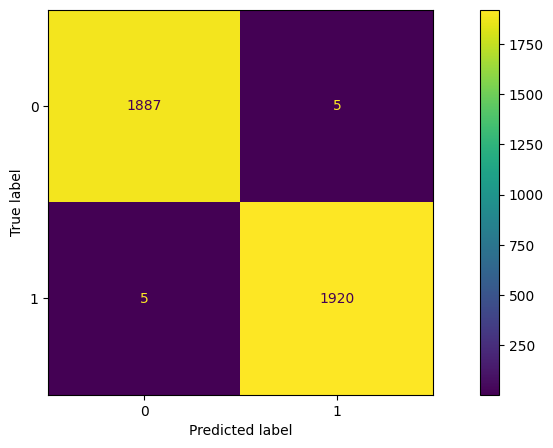

In [51]:
# Creating a confusion matrix to visualise the results of the classification model

# Computing values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.show()

The **upper-left** quadrant displays the number of **true negatives**: the number of opinions that the model accurately classified as so.

The **upper-right** quadrant displays the number of **false positives**: the number of opinions that the model misclassified as claims.

The **lower-left** quadrant displays the number of **false negatives**: the number of claims that the model misclassified as opinions.

The **lower-right** quadrant displays the number of **true positives**: the number of claims that the model accurately classified as so.

A perfect model would yield **all true negatives** and **true positives**, and **no false negatives** or **false positives**.

As the above confusion matrix shows, this model does not produce any **false negatives**.

In [52]:
# Creating a classification report
# Creating classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were **10** misclassifications&mdash;five false postives and five false negatives.

# <span style="color:red; font-size:20px;">XGBoost</span>

**Now, we evaluate the XGBoost model on the validation set.**

In [53]:
#Evaluating XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

In [54]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

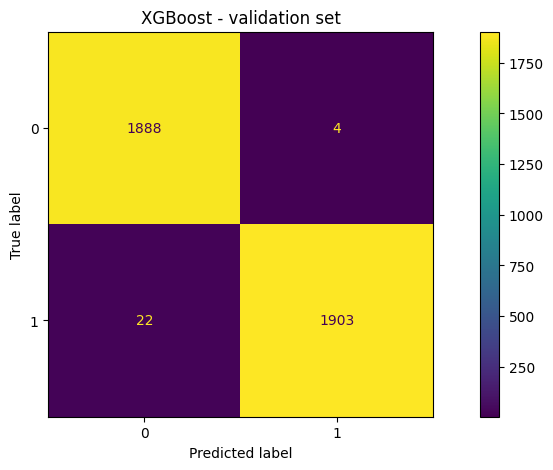

In [55]:
# Computing values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.title('XGBoost - validation set');
plt.show()

In [56]:
# Creating a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The results of the **XGBoost model** were also nearly perfect. However, its errors tended to be **false negatives**. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

<span style="background-color:deepskyblue;
             color:yellow;
             font-size:25px;
             text-align:center;
               border-radius:20px 70px;
             font-weight:bold;
             border:2px solid yellow;
              padding:15px 30px;">Using champion model to predict on test data
</span>

Both **random forest** and **XGBoost model** architectures resulted in nearly perfect models. Nonetheless, in this case **random forest** performed a little bit better, so it is the **champion model**.

Now, use the champion model to predict on the test data.

In [57]:
# Using champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

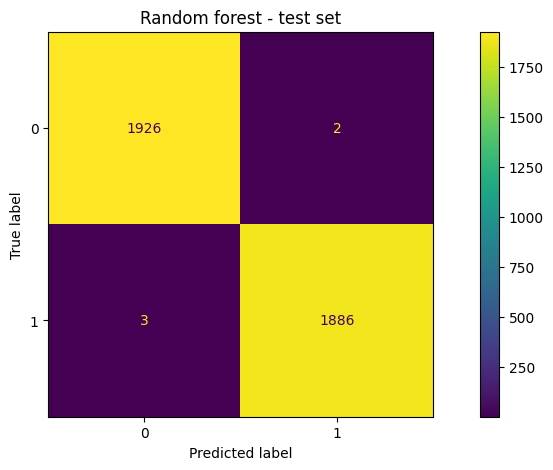

In [58]:
# Computing values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.title('Random forest - test set');
plt.show()

# <span style="color:red; font-size:20px;">Feature importances of champion model</span>

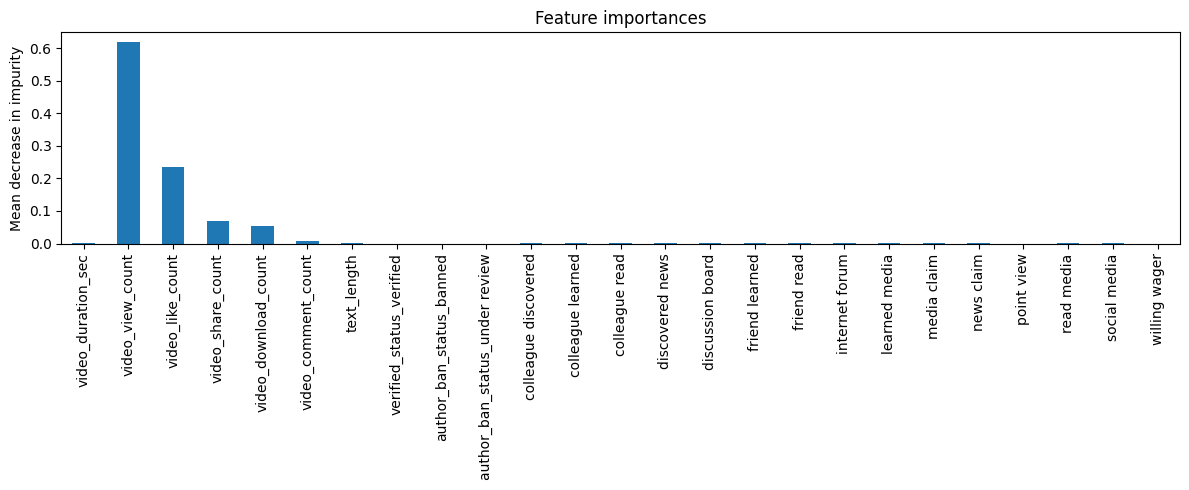

In [59]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()


The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.